### Video-Based Gaze Tracking tutorial (1/5)
This is a lecture of the Video-Based Gaze Tracking tutorial of the [Bridging the Technological Gap Summer Workshop](https://psychandneuro.duke.edu/opportunity/bridging-technological-gap-summer-workshop), July 31st – August 6th, 2022, German Primate Center, Göttingen, Germany.

More info at [https://github.com/erkil1452/gaze_workshop_public](https://github.com/erkil1452/gaze_workshop_public).

Made by Petr Kellnhofer, 2022.

In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path('.').resolve().absolute().parent))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import imageio
import dlib

# Automatically reload our library.
%reload_ext autoreload
%autoreload 1
from src import gaze_utils as gu
%aimport src

DATA_PATH = Path('.').resolve().absolute().parent / 'data'
sample_data = gu.WorkshopDataset(DATA_PATH / 'gazecapture' / '00192')

## 1. Face capture

In this section we cover topics of capturing an image from either a webcam or a file, decting a face region and cropping it.

### 1.1 Capture an image

We can obtain an image either from a camera or from a file on our drive. If you have a webcam, try the following code. Otherwise skip to loading images from drive.

Frame size: (720, 1280, 3)


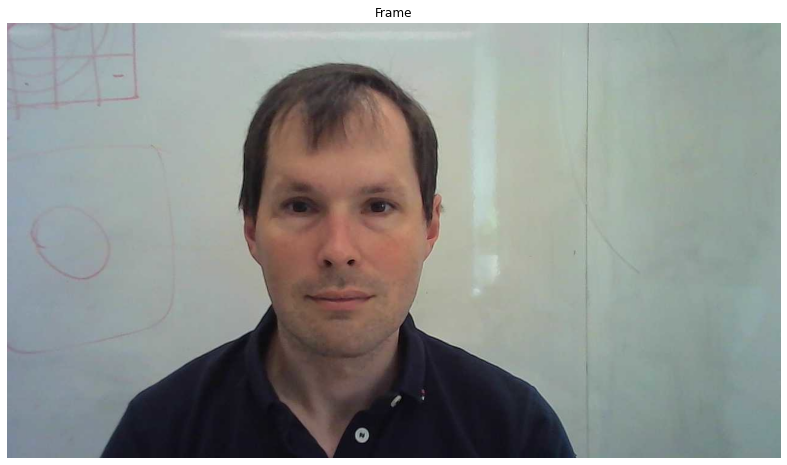

In [9]:
# Which camera connected to the computer to use? Default camera = 0.
camera_index = 0
# Resolution to capture? Match your camera resolution or use default.
camera_resolution = [1280, 720]

# Open OpenCV camera interface for given camera.
cap = cv2.VideoCapture(camera_index)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, camera_resolution[0])
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, camera_resolution[1])

# Capture a frame from the camera.
res, frame = cap.read()

# Close the camera.
cap.release()

# Left <-> right mirror (if needed).
frame = np.fliplr(frame)

# Color space conversion BGR -> RGB.
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display frame has shape (height, width, 3)
print(f'Frame size: {frame.shape}')

# Show image.
gu.show_images([frame], ['Frame'])

Is the image too bright or too dark? Try again. Still bad? Try opening another webcam application to let the camera auto-adjust. Do not forget to close the camera handle before doing (`cap.release()`) or the other program will not be able to access it!

For convenience, let us write and test a method that captures and returns one frame from the camera.

In [10]:
def capture_frame() -> np.array:
    """ Captures and returns a frame from a camera. """
    ### TODO
    raise NotImplementedError()
    return image

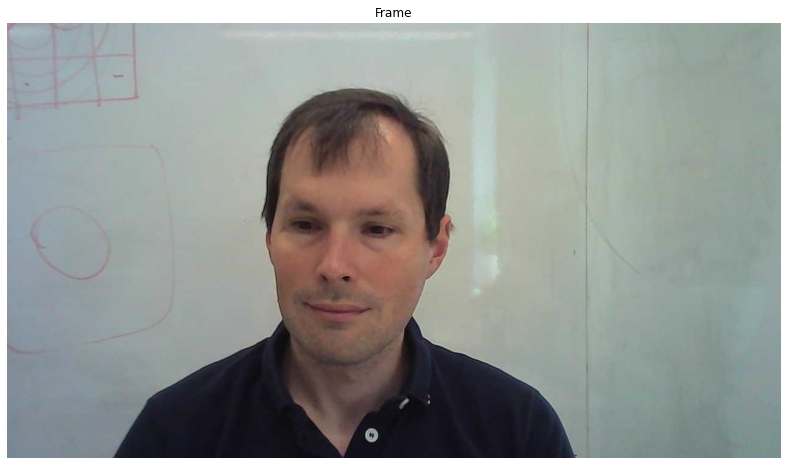

In [14]:
# Test the method.
frame = capture_frame()
gu.show_images([frame], ['Frame'])

Note that opening and closing camera (`cap = cv2.VideoCapture(camera_index)` and `cap.release()`) is very slow. For a serious capture session we would keep the camera open until we are done. However, do not forget to close it eventually or you will have issues with your next Zoom call. Remark: The camera is automatically closed when python or jupuyter terminate.

In case you do not have a webcam OR it does not work, we provide a sample data set `sample_data` with a convenient method `.get_image(index)` which loads one of couple predefined images from the [GazeCapture dataset](https://gazecapture.csail.mit.edu/download.php).

Frame size: (640, 480, 3)


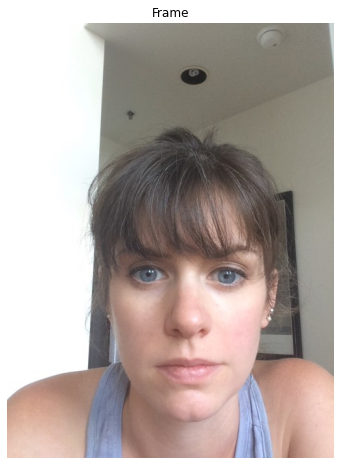

In [15]:
frame = sample_data.get_image(0)

# Display frame has shape (height, width, 3)
print(f'Frame size: {frame.shape}')

# Color space conversion BGR -> RGB.
gu.show_images([frame], ['Frame'])

### 1.2 Face detection

Now we will detect the face region using dlib library. First we will try the simpler face detector based on HOG features and Linear SVM classifier
(see more [examples](https://pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/)).

The first step is to import the `dlib` library and initialize the face detector. This is a more classical detector that does not use neural networks but HOG features and SVM classifier.

In [16]:
# Create a new face detector.
face_detector = dlib.get_frontal_face_detector()

Now we just feed our image into a detector to get a list of rectangles marking the detected faces.

In [17]:
# Run the face detector. Arg 1 => upsample input image by factor of 1 (== identity).
faces = face_detector(frame, 1)
print(f'Detected {len(faces)} face(s):\n{faces}')

Detected 1 face(s):
rectangles[[(141, 290) (409, 558)]]


We can easily visualize the detected faces using OpenCV.

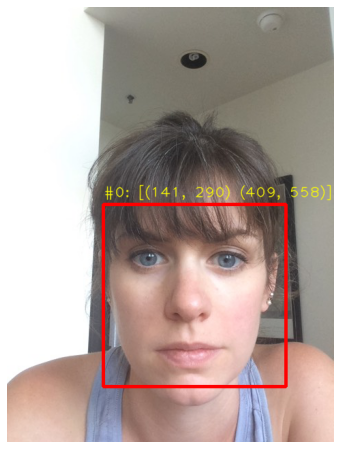

In [18]:
# Visualize using OpenCV.
im_detections = frame.copy()
for i, rect in enumerate(faces):
    cv2.rectangle(im_detections, (rect.left(), rect.bottom()), (rect.right(), rect.top()), color=(255, 0, 0), thickness=4)
    cv2.putText(im_detections, f'#{i}: {rect}', (rect.left(), rect.top() - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 0), 1, lineType = cv2.LINE_AA)
gu.show_images([im_detections]);

Most likely, you only received one face detection (unless another person was in the view). In some cases, the detector may return multiple propositions. To resolve this ambiguity, we can use [Non Max Suppression](https://medium.com/analytics-vidhya/non-max-suppression-nms-6623e6572536) which merges overlapping predictions. Instead, we will just select the largest face.

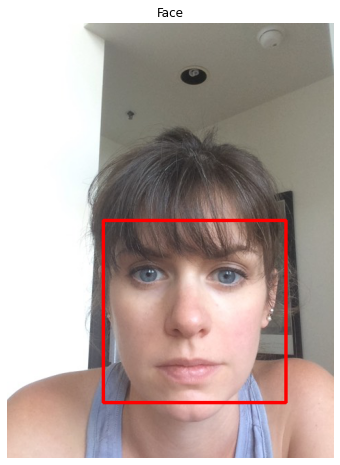

In [19]:
# Find largest face
max_area = 0
face = None
for rect in faces:
    if rect.area() > max_area:
        max_area = rect.area()
        face = rect

im_one_face = frame.copy()
cv2.rectangle(im_one_face, (face.left(), face.bottom()), (face.right(), face.top()), color=(255, 0, 0), thickness=4)
gu.show_images([im_one_face], ['Face']);


Task: Let's again implement a helpful method for later that takes an image from camera and returns a single face rectangle (or `None`).

In [20]:
def detect_face(im: np.array) -> dlib.rectangle:
    """ Detects the largest face in an image and returns its rectangle. """
    raise NotImplementedError()
    return face_rect

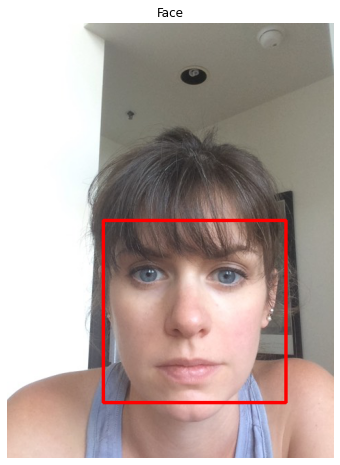

In [22]:
# Test it
face = detect_face(frame)
im_one_face = frame.copy()
cv2.rectangle(im_one_face, (face.left(), face.bottom()), (face.right(), face.top()), color=(255, 0, 0), thickness=4)
gu.show_images([im_one_face], ['Face']);

### 1.3 Neural face detector

Sometimes the HOG+SVM detector is not robust enough. Let's try a more difficult image. Load this sample image from drive and try to run the face detector again.
Note: Do not forget to convert the image to grayscale.

No face found!


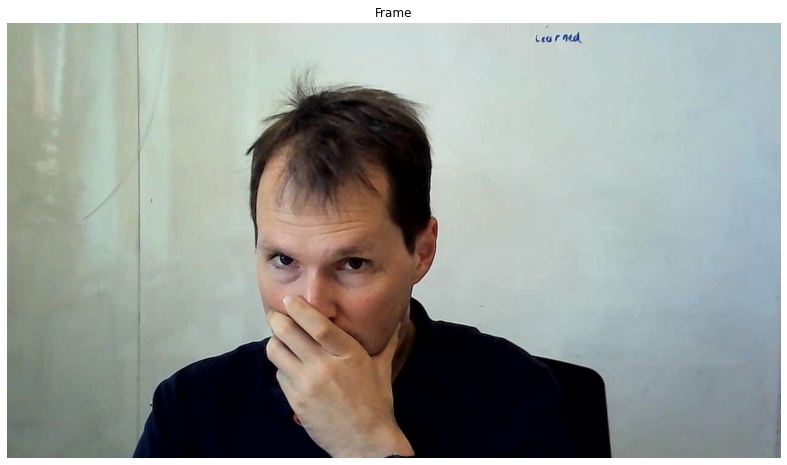

In [23]:
# Load an image from drive.
frame = imageio.imread(DATA_PATH / 'samples' / 'difficult.jpg')

# Try our detector.
face = detect_face(frame)
if face is None:
    print('No face found!')
    gu.show_images([frame], ['Frame']);
else:
    im_one_face = frame.copy()
    cv2.rectangle(im_one_face, (face.left(), face.bottom()), (face.right(), face.top()), color=(255, 0, 0), thickness=4)
    gu.show_images([im_one_face], ['Face']);

Conveniently, the dlib library also features a neural face detector based on a convolutional neural network (CNN):
King, Davis E. "Max-margin object detection." arXiv preprint arXiv:1502.00046 (2015). [arxiv](https://arxiv.org/pdf/1502.00046.pdf)

From dlib's documentation:
"This is the same loss used by the popular SVM+HOG object detector [...] except here we replace the HOG features with a CNN and train the entire detector end-to-end.  This allows us to make much more powerful detectors."

The initialization is similar to the HOG detector but we need to provide path to the pretrained weights downloaded from internet.

In [24]:
# Create a CNN based detector.
face_detector_cnn = dlib.cnn_face_detection_model_v1(str(DATA_PATH / 'params/mmod_human_face_detector.dat'))

We can now feed in the image exactly the same way as with the HOG detector. Just have patience, it is a lot more computation...

In [25]:
faces_cnn = face_detector_cnn(frame, 0)
print(f'Detected {len(faces_cnn)} face(s):\n{faces_cnn}')

Detected 1 face(s):


Note that the output is not a list of rectangles but list of objects wrapping the rectangles as `res.rect` field. However, we can still visualize them pretty easily and compare both detectors...

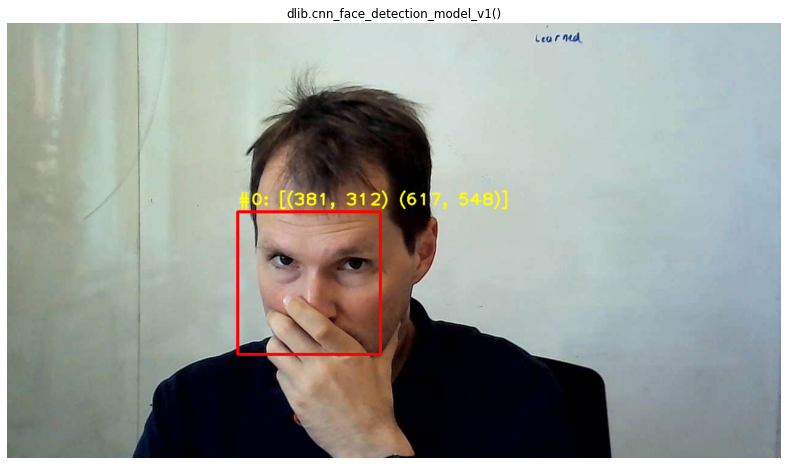

In [26]:
im_detections_cnn = frame.copy()
for i, res in enumerate(faces_cnn):
    rect = res.rect
    cv2.rectangle(im_detections_cnn, (rect.left(), rect.bottom()), (rect.right(), rect.top()), color=(255, 0, 0), thickness=4)
    cv2.putText(im_detections_cnn, f'#{i}: {rect}', (rect.left(), rect.top() - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 0), 2, lineType = cv2.LINE_AA)
gu.show_images([im_detections_cnn], ['dlib.cnn_face_detection_model_v1()']);

The performance could be accelerated by GPU but for our purposes we will just turn back to the much cheaper HOG-based detector. 

Excercise: Capture a new frame from camera or sample dataset and run both face detectors on them.

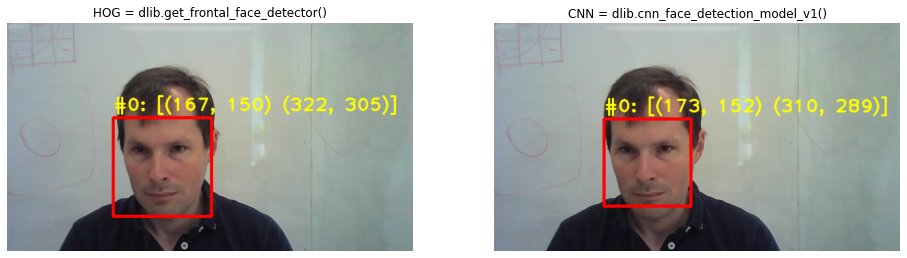

In [27]:
# Capture a frame.
frame = capture_frame()
# Make faster by resizing to half-size.
frame = cv2.resize(frame, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
# Run detectors.
face_hog = detect_face(frame)
face_cnn = face_detector_cnn(frame)
if len(face_cnn) > 0:
    face_cnn = face_cnn[0].rect    
else:
    face_cnn = None
# Run
imgs = []
for rect in [face_hog, face_cnn]:
    im = frame.copy()
    cv2.rectangle(im, (rect.left(), rect.bottom()), (rect.right(), rect.top()), color=(255, 0, 0), thickness=4)
    cv2.putText(im, f'#{i}: {rect}', (rect.left(), rect.top() - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 0), 2, lineType = cv2.LINE_AA)
    imgs += [im]
gu.show_images(imgs, ['HOG = dlib.get_frontal_face_detector()', 'CNN = dlib.cnn_face_detection_model_v1()']);

### 1.4 Crop the face.

We will better utilize the network capacity if we only feed it relevant data. In this tutorial we will settle with the face region.

Your next task is to write a method which takes in an image and the detected rectangle and returns a **square** crop of the face. Make sure to handle cases when the crop region reaches out of the image bounds. Append zeros if needed.

In [30]:
def crop_image(image: np.array, rectangle: dlib.rectangle, scale_factor: float = 1.2) -> float:
    """ Return a rectangular crop of the image. Enlarge the size of the rectangle by a factor. """
    # 1. Compute left and right corner coordinates.
    face_size = max(rectangle.width(), rectangle.height()) * scale_factor
    # TODO
    # 2. Determine how much is out of bounds.
    # TODO
    # 3. Add zero padding for the out-of-bounds region.
    # TODO
    raise NotImplementedError()
    return crop # np.array

Test it on a tricky image from sample data.

Crop shape: (324, 324, 3)


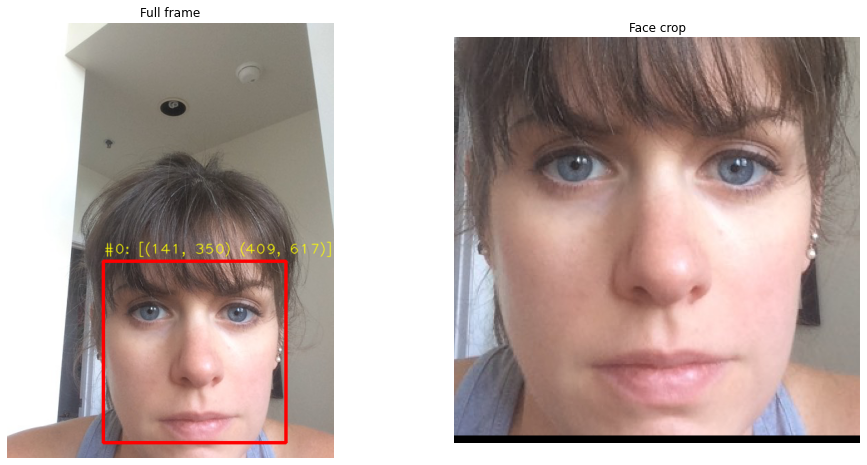

In [32]:
# Prepare data.
frame = sample_data.get_image(8)
rect = detect_face(frame)

# Crop.
face_crop = crop_image(frame, rect, 1.2)

# Visualize.
print(f'Crop shape: {face_crop.shape}')
from src.gaze_utils import draw_rectangles
gu.show_images([draw_rectangles(frame, [rect]), face_crop], ['Full frame', 'Face crop'])

That's it for the face detection. For more examples visit [https://pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/](https://pyimagesearch.com/2021/04/19/face-detection-with-dlib-hog-and-cnn/).